Вот скрипт, который загружает обученную модель, применяет её к тому же датафрейму и добавляет новую колонку с прогнозами (PREDICTION).

Что делает этот скрипт:  
Загружает данные из базы, как и в обучающем скрипте.  
Кодирует свечи (используется тот же алгоритм CANDLE_CODE).  
Преобразует коды свечей в числовые метки (CANDLE_INT).  
Определяет структуру нейросети, чтобы она совпадала с обученной.  
Загружает веса модели из best_model_03.pth.  
Прогнозирует движение цены {0: "📉 STRONG DOWN", 1: "🔹 FLAT", 2: "📈 STRONG UP"}.  
Добавляет колонку PREDICTION в датафрейм.  
Сохраняет результат в predictions_fut_lih_03.csv.  
Теперь в файле predictions_fut_lih_03.csv у вас будет таблица с прогнозами.

In [34]:
import sqlite3
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

# === ФИКСАЦИЯ СЛУЧАЙНЫХ ЧИСЕЛ ===
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1)

# === ЗАГРУЗКА ДАННЫХ ===
db_path = Path(r'C:\Users\Alkor\gd\data_quote_db\RTS_futures_options_day.db')

with sqlite3.connect(db_path) as conn:
    df_fut = pd.read_sql_query(
        "SELECT TRADEDATE, OPEN, LOW, HIGH, CLOSE, VOLUME FROM Futures",
        conn
    )

def encode_candle(row):
    open_, low, high, close = row['OPEN'], row['LOW'], row['HIGH'], row['CLOSE']
    direction = 1 if close > open_ else (0 if close < open_ else 2)
    upper_shadow = high - max(open_, close)
    lower_shadow = min(open_, close) - low
    body = abs(close - open_)
    
    def classify_shadow(shadow, body):
        return 0 if shadow < 0.1 * body else (1 if shadow < 0.5 * body else 2)
    
    return f"{direction}{classify_shadow(upper_shadow, body)}{classify_shadow(lower_shadow, body)}"

df_fut['CANDLE_CODE'] = df_fut.apply(encode_candle, axis=1)

# === КОДИРОВАНИЕ КОДОВ СВЕЧЕЙ ===
unique_codes = sorted(df_fut['CANDLE_CODE'].unique())
code_to_int = {code: i for i, code in enumerate(unique_codes)}
df_fut['CANDLE_INT'] = df_fut['CANDLE_CODE'].map(code_to_int)

window_size = 20  
X_pred = []
for i in range(len(df_fut) - window_size):
    X_pred.append(df_fut['CANDLE_INT'].iloc[i:i+window_size].values)
X_pred = np.array(X_pred)

# === СОЗДАНИЕ DATASET ===
class CandlestickDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx]

dataset = CandlestickDataset(X_pred)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# === ОПРЕДЕЛЕНИЕ МОДЕЛИ ===
class CandleLSTM(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(CandleLSTM, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return self.softmax(x)

# === ЗАГРУЗКА МОДЕЛИ ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CandleLSTM(vocab_size=len(unique_codes), embedding_dim=8, hidden_dim=32, output_dim=3).to(device)
model.load_state_dict(torch.load("best_model_03.pth"))
model.eval()

# === ПРОГНОЗ ===
predictions = []
with torch.no_grad():
    for X_batch in dataloader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch).argmax(dim=1)
        predictions.extend(y_pred.cpu().numpy())

# === ДОБАВЛЕНИЕ РЕЗУЛЬТАТОВ В ДАТАФРЕЙМ ===
df_fut = df_fut.iloc[window_size:].copy()
df_fut['PREDICTION'] = predictions
# prediction_map = {0: "📉 STRONG DOWN", 1: "🔹 FLAT", 2: "📈 STRONG UP"}
# df_fut['PREDICTION'] = df_fut['PREDICTION'].map(prediction_map)

# === СОХРАНЕНИЕ В ФАЙЛ ===
df_fut.to_csv("predictions_fut_lih_03.csv", index=False)
print("✅ Прогнозы сохранены в predictions_fut_lih_03.csv")


✅ Прогнозы сохранены в predictions_fut_lih_03.csv


Этот скрипт:
✅ Загружает файл predictions_fut_lih_03.csv
✅ Отбирает последние 20% данных
✅ Смещает прогноз на один бар вперед
✅ Рассчитывает результат моделирования сделок (только по STRONG сигналам)
✅ Строит кумулятивный график изменения счета

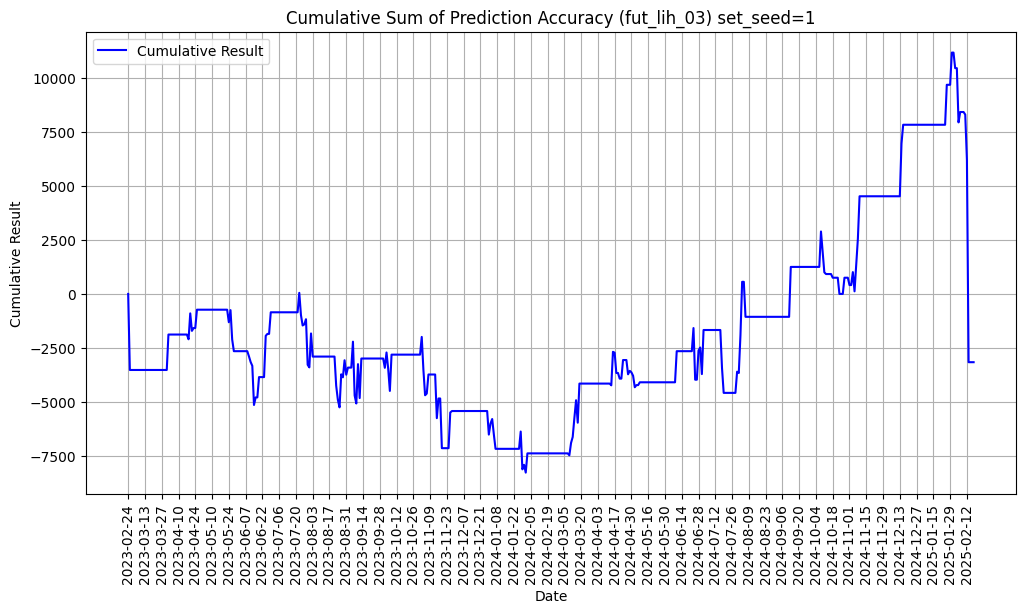

In [35]:
import matplotlib.pyplot as plt

# === 1. ЗАГРУЗКА ФАЙЛА И ОТБОР ПОСЛЕДНИХ 20% ===
df = pd.read_csv("predictions_fut_lih_03.csv")

split = int(len(df) * 0.8)  # 80% - обучающая выборка, 20% - тестовая
df = df.iloc[split:].copy()  # Берем последние 20%

# === 2. СМЕЩЕНИЕ ПРОГНОЗА НА ОДИН БАР ВПЕРЁД ===
df["PREDICTION_SHIFTED"] = df["PREDICTION"].shift(1)  # Смещаем вверх
# df

# === 3. РАСЧЁТ РЕЗУЛЬТАТОВ ПРОГНОЗА ===
def calculate_result(row):
    if pd.isna(row["PREDICTION_SHIFTED"]):  # Если NaN после сдвига
        return 0
    
    if row["PREDICTION_SHIFTED"] == 1:  # По сигналу FLAT сделки нет
        return 0
    
    true_direction = 1 if row["CLOSE"] > row["OPEN"] else 0
    predicted_direction = 1 if row["PREDICTION_SHIFTED"] == 2 else 0
    
    difference = abs(row["CLOSE"] - row["OPEN"])
    return difference if true_direction == predicted_direction else -difference

# Добавляем колонку результата
df["RESULT"] = df.apply(calculate_result, axis=1)

# === 4. ПОСТРОЕНИЕ КУМУЛЯТИВНОГО ГРАФИКА ===
df["CUMULATIVE_RESULT"] = df["RESULT"].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(df["TRADEDATE"], df["CUMULATIVE_RESULT"], label="Cumulative Result", color="b")
plt.xlabel("Date")
plt.ylabel("Cumulative Result")
plt.title("Cumulative Sum of Prediction Accuracy (fut_lih_03) set_seed=1")
plt.legend()
plt.grid()

plt.xticks(df["TRADEDATE"][::10], rotation=90)
plt.show()


In [36]:
df

,TRADEDATE,OPEN,LOW,HIGH,CLOSE,VOLUME,CANDLE_CODE,CANDLE_INT,PREDICTION,PREDICTION_SHIFTED,RESULT,CUMULATIVE_RESULT
2017,2023-02-24,93990.0,92000.0,94890.0,92310.0,96469,21,7,0,NaN,0.0,0.0
2018,2023-02-27,92350.0,92120.0,96090.0,95870.0,122864,100,9,1,0.0,-3520.0,-3520.0
2019,2023-02-28,95900.0,95110.0,96780.0,95690.0,102489,22,8,1,1.0,0.0,-3520.0
2020,2023-03-01,95750.0,95320.0,97170.0,96740.0,93995,111,13,1,1.0,0.0,-3520.0
2021,2023-03-02,96730.0,93970.0,96970.0,94900.0,139013,12,5,1,1.0,0.0,-3520.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2517,2025-02-12,98600.0,98120.0,101480.0,100700.0,124069,111,13,0,0.0,-2100.0,6200.0
2518,2025-02-13,100570.0,100080.0,111010.0,109930.0,247083,110,12,1,0.0,-9360.0,-3160.0
2519,2025-02-14,109750.0,106470.0,114130.0,108620.0,282242,22,8,1,1.0,0.0,-3160.0
2520,2025-02-17,108960.0,108050.0,115370.0,115170.0,183356,101,10,1,1.0,0.0,-3160.0
